## School Dataset

In [7]:
import pandas as pd
from sodapy import Socrata


client = Socrata("data.cityofnewyork.us", None)

'''
Takes long time to run
# Define a list of the URLs for the attendance datasets
attendance_urls = [
    "xwxx-rnki",
    "wpqj-3buw",
    "pffu-gbfi",
    "46g3-savk",
    "xc44-2jrh"
]

# Create a list comprehension to read each CSV file into a data frame and store it in a list
dfs = [pd.DataFrame.from_records(client.get_all(url)) for url in attendance_urls]

# Concatenate all the data frames in the dfs list into a single data frame
attendance_df = pd.concat(dfs)

attendance_df.to_csv('Merged_Attendance.csv')
'''

results = client.get_all("qybk-bjjc")

schools_df = pd.DataFrame.from_records(results,columns=['longitude','latitude','dbn'])
schools_df.drop_duplicates(inplace=True)
schools_df['latitude']=schools_df['latitude'].astype(float)
schools_df['longitude']=schools_df['longitude'].astype(float)


attendance_df=pd.read_csv('Merged_Attendance.csv', dtype={'school': str,'date': str},index_col=0)
attendance_df.drop_duplicates(inplace=True)


# drop duplicate rows
attendance_df.drop_duplicates(inplace=True)

num_nan = attendance_df['school'].isnull().sum()
print(f"There are {num_nan} NaN values in column 'school'.")

# drop rows with NaN values in column 'school'
attendance_df.dropna(subset=['school'],inplace=True)


school_df = pd.merge(attendance_df, schools_df, left_on='school', right_on='dbn', how='left')
del school_df['dbn']

# Print the number of rows not found
print(f"{school_df['latitude'].isnull().sum()} rows were not found in the schools dataset.")
school_df.dropna(subset=['latitude'],inplace=True)

# Prints the first columns and few rows of the dataframe
print(len(school_df))
school_df.head()



There are 727707 NaN values in column 'school'.
84491 rows were not found in the schools dataset.
2992352


,school,date,schoolyear,enrolled,present,absent,released,longitude,latitude
0,01M015,20060905,20062007,252.0,226.0,26.0,0.0,-73.979022,40.721807
1,01M015,20060906,20062007,248.0,227.0,21.0,0.0,-73.979022,40.721807
2,01M015,20060907,20062007,245.0,228.0,17.0,0.0,-73.979022,40.721807
3,01M015,20060908,20062007,246.0,226.0,20.0,0.0,-73.979022,40.721807
4,01M015,20060911,20062007,248.0,223.0,25.0,0.0,-73.979022,40.721807


In [9]:
import datetime
start_time = time.time()
school_df['date'] = school_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d').strftime('%Y-%m-%d'))
school_df['date'] = pd.to_datetime(school_df['date'])
school_df['month'] = (school_df['date'].dt.year-2006)*12+school_df['date'].dt.month
school_df['attendance'] =  (school_df['present']) / school_df['enrolled']
print(f"data chunck loaded in {time.time() - start_time:.2f} seconds.")


data chunck loaded in 28.17 seconds.


In [10]:
grouped_df = school_df.groupby(['date'])['attendance'].agg(['mean', 'std']).reset_index()
school_df = pd.merge(school_df, grouped_df, on=['date'])
school_df['z_score'] = (school_df['attendance'] - school_df['mean']) / school_df['std']

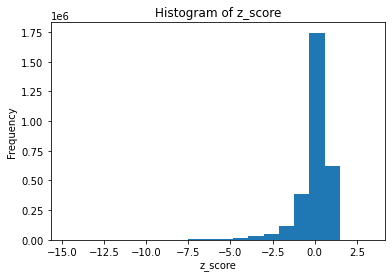

In [11]:
import matplotlib.pyplot as plt

z_scores = school_df['z_score']
plt.hist(z_scores, bins=20)
plt.xlabel('z_score')
plt.ylabel('Frequency')
plt.title('Histogram of z_score')
plt.show()

## Bike Dataset

In [36]:
import pandas as pd
import time


client = Socrata("data.cityofnewyork.us", None)

'''
Takes long time to run 
results = client.get_all("uczf-rk3c")
count_df = pd.DataFrame.from_records(results)
count_df.to_csv('Bike_count.csv')
'''
count_df=pd.read_csv('Bike_count.csv',dtype={'id':str},index_col=0)

results = client.get_all("smn3-rzf9")
count_location = pd.DataFrame.from_records(results)
count_location = count_location[['latitude','longitude','id']]


# Merge the two datasets on the "id" column
bike_df = pd.merge(count_df, count_location, on='id')

# Count the number of rows in the first dataset that are not in the merged dataset
non_matching_rows = bike_df[~bike_df['id'].isin(count_df['id'])].shape[0]

# Print the number of non-matching rows
print(f"Number of non-matching rows: {non_matching_rows}")

# Prints the first columns and few rows of the dataframe
bike_df.head()

Number of non-matching rows: 0


,countid,id,date,counts,status,latitude,longitude
0,10014848,100009425,2022-06-24T00:00:00.000,15,0,40.6712884581027,-73.9713816508519
1,10014849,100009425,2022-06-24T00:15:00.000,12,0,40.6712884581027,-73.9713816508519
2,10014850,100009425,2022-06-24T00:30:00.000,14,0,40.6712884581027,-73.9713816508519
3,10014851,100009425,2022-06-24T00:45:00.000,5,0,40.6712884581027,-73.9713816508519
4,10014852,100009425,2022-06-24T01:00:00.000,10,0,40.6712884581027,-73.9713816508519


In [37]:
count_df['date'] = pd.to_datetime(count_df['date'])
count_df['15_min_frame_week']=count_df['date'].dt.weekday*96+count_df['date'].dt.hour*4+count_df['date'].dt.minute/15
grouped_df = count_df.groupby(['id', '15_min_frame_week'])['counts'].agg(['mean', 'std']).reset_index()
count_df = pd.merge(count_df, grouped_df, on=['id', '15_min_frame_week'])
count_df['z_score_bike'] = (count_df['counts'] - count_df['mean']) / count_df['std']

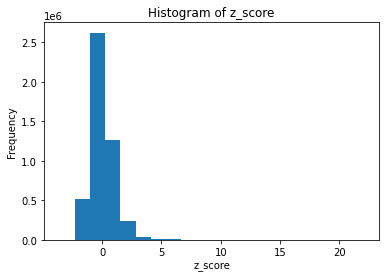

In [38]:
z_scores = count_df['z_score_bike']
plt.hist(z_scores, bins=20)
plt.xlabel('z_score')
plt.ylabel('Frequency')
plt.title('Histogram of z_score')
plt.show()

## Borough Population

In [20]:
start_time = time.time()

client = Socrata("data.cityofnewyork.us", None)

results = client.get_all("xywu-7bv9")
bor_population = pd.DataFrame.from_records(results)

print(f"Population data frame loaded in {time.time() - start_time:.2f} seconds.")

#bor_population = pd.read_csv('https://data.cityofnewyork.us/resource/xywu-7bv9.csv')
bor_population['borough'] = bor_population['borough'].str.upper()

# Prints the first columns and few rows of the dataframe
print(bor_population.columns)
bor_population.head()

Population data frame loaded in 0.80 seconds.
Index(['age_group', 'borough', '_1950', '_1950_boro_share_of_nyc_total',
       '_1960', '_1960_boro_share_of_nyc_total', '_1970',
       '_1970_boro_share_of_nyc_total', '_1980',
       '_1980_boro_share_of_nyc_total', '_1990',
       '_1990_boro_share_of_nyc_total', '_2000',
       '_2000_boro_share_of_nyc_total', '_2010',
       '_2010_boro_share_of_nyc_total', '_2020',
       '_2020_boro_share_of_nyc_total', '_2030',
       '_2030_boro_share_of_nyc_total', '_2040',
       '_2040_boro_share_of_nyc_total'],
      dtype='object')


,age_group,borough,_1950,_1950_boro_share_of_nyc_total,_1960,_1960_boro_share_of_nyc_total,_1970,_1970_boro_share_of_nyc_total,_1980,_1980_boro_share_of_nyc_total,...,_2000,_2000_boro_share_of_nyc_total,_2010,_2010_boro_share_of_nyc_total,_2020,_2020_boro_share_of_nyc_total,_2030,_2030_boro_share_of_nyc_total,_2040,_2040_boro_share_of_nyc_total
0,Total Population,NYC TOTAL,7891957,100.00,7781984,100.00,7894862,100.00,7071639,100.00,...,8008278,100.00,8242624,100.00,8550971,100.00,8821027,100.00,9025145,100.00
1,Total Population,BRONX,1451277,18.39,1424815,18.31,1471701,18.64,1168972,16.53,...,1332650,16.64,1385108,16.80,1446788,16.92,1518998,17.22,1579245,17.50
2,Total Population,BROOKLYN,2738175,34.70,2627319,33.76,2602012,32.96,2230936,31.55,...,2465326,30.78,2552911,30.97,2648452,30.97,2754009,31.22,2840525,31.47
3,Total Population,MANHATTAN,1960101,24.84,1698281,21.82,1539233,19.50,1428285,20.20,...,1537195,19.20,1585873,19.24,1638281,19.16,1676720,19.01,1691617,18.74
4,Total Population,QUEENS,1550849,19.65,1809578,23.25,1986473,25.16,1891325,26.75,...,2229379,27.84,2250002,27.30,2330295,27.25,2373551,26.91,2412649,26.73


## Construction-related projects applications

In [35]:
'''
Takes long time
results = client.get_all("ic3t-wcy2")
construction_df = pd.DataFrame.from_records(results)
construction_df=construction_df[['job__','borough','gis_latitude', 'gis_longitude','total_est__fee', 'proposed_no_of_stories', 'job_type','proposed_occupancy']]
construction_df.to_csv('Construction_applications_v2.csv')
'''
construction_df=pd.read_csv('Construction_applications_v2.csv')

# Prints the first columns and few rows of the dataframe
print(construction_df.columns)
construction_df.head()

Index(['Unnamed: 0', 'job__', 'borough', 'gis_latitude', 'gis_longitude',
       'total_est__fee', 'proposed_no_of_stories', 'job_type',
       'proposed_occupancy'],
      dtype='object')


,Unnamed: 0,job__,borough,gis_latitude,gis_longitude,total_est__fee,proposed_no_of_stories,job_type,proposed_occupancy
0,0,301793156,BROOKLYN,40.685185,-73.912220,$200.00,3,A3,NaN
1,1,301776077,BROOKLYN,40.717318,-73.955431,$150.30,5,A2,NaN
2,2,301776291,BROOKLYN,40.638728,-74.001250,$682.30,3,A1,J-0
3,3,302163557,BROOKLYN,40.687317,-73.979159,$9866.44,12,A1,J-2
4,4,301773631,BROOKLYN,40.659043,-73.960526,$603.50,3,A1,COM


## Demographic Data

### Interesting but I couldn't merge the jurisdiction_name with anything

In [32]:
demographic_df=pd.read_csv('https://data.cityofnewyork.us/resource/kku6-nxdu.csv')

# Prints the first columns and few rows of the dataframe
print(demographic_df.columns)
demographic_df.head()

Index(['jurisdiction_name', 'count_participants', 'count_female',
       'percent_female', 'count_male', 'percent_male', 'count_gender_unknown',
       'percent_gender_unknown', 'count_gender_total', 'percent_gender_total',
       'count_pacific_islander', 'percent_pacific_islander',
       'count_hispanic_latino', 'percent_hispanic_latino',
       'count_american_indian', 'percent_american_indian',
       'count_asian_non_hispanic', 'percent_asian_non_hispanic',
       'count_white_non_hispanic', 'percent_white_non_hispanic',
       'count_black_non_hispanic', 'percent_black_non_hispanic',
       'count_other_ethnicity', 'percent_other_ethnicity',
       'count_ethnicity_unknown', 'percent_ethnicity_unknown',
       'count_ethnicity_total', 'percent_ethnicity_total',
       'count_permanent_resident_alien', 'percent_permanent_resident_alien',
       'count_us_citizen', 'percent_us_citizen', 'count_other_citizen_status',
       'percent_other_citizen_status', 'count_citizen_status_unkn

,jurisdiction_name,count_participants,count_female,percent_female,count_male,percent_male,count_gender_unknown,percent_gender_unknown,count_gender_total,percent_gender_total,...,count_citizen_status_total,percent_citizen_status_total,count_receives_public_assistance,percent_receives_public_assistance,count_nreceives_public_assistance,percent_nreceives_public_assistance,count_public_assistance_unknown,percent_public_assistance_unknown,count_public_assistance_total,percent_public_assistance_total
0,10001,44,22,0.50,22,0.50,0,0,44,100,...,44,100,20,0.45,24,0.55,0,0,44,100
1,10002,35,19,0.54,16,0.46,0,0,35,100,...,35,100,2,0.06,33,0.94,0,0,35,100
2,10003,1,1,1.00,0,0.00,0,0,1,100,...,1,100,0,0.00,1,1.00,0,0,1,100
3,10004,0,0,0.00,0,0.00,0,0,0,0,...,0,0,0,0.00,0,0.00,0,0,0,0
4,10005,2,2,1.00,0,0.00,0,0,2,100,...,2,100,0,0.00,2,1.00,0,0,2,100


## Shooting dataset

In [6]:
#shooting_df = pd.read_csv('https://data.cityofnewyork.us/resource/833y-fsy8.csv')
import pandas as pd
start_time = time.time()

results = client.get_all("833y-fsy8")

print(f"Shooting data frame loaded in {time.time() - start_time:.2f} seconds.")


# Convert to pandas DataFrame
shooting_df = pd.DataFrame.from_records(results)


print(shooting_df.columns)
shooting_df.head()

Shooting data frame loaded in 0.00 seconds.
Index(['incident_key', 'occur_date', 'occur_time', 'boro', 'precinct',
       'jurisdiction_code', 'statistical_murder_flag', 'vic_age_group',
       'vic_sex', 'vic_race', 'x_coord_cd', 'y_coord_cd', 'latitude',
       'longitude', 'geocoded_column', ':@computed_region_yeji_bk3q',
       ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih',
       ':@computed_region_efsh_h5xi', ':@computed_region_f5dn_yrer',
       'perp_age_group', 'perp_sex', 'perp_race', 'location_desc',
       'loc_of_occur_desc', 'loc_classfctn_desc'],
      dtype='object')


,incident_key,occur_date,occur_time,boro,precinct,jurisdiction_code,statistical_murder_flag,vic_age_group,vic_sex,vic_race,...,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,perp_age_group,perp_sex,perp_race,location_desc,loc_of_occur_desc,loc_classfctn_desc
0,228798151,2021-05-27T00:00:00.000,21:30:00,QUEENS,105,0,False,18-24,M,BLACK,...,47,63,24018,63,NaN,NaN,NaN,NaN,NaN,NaN
1,137471050,2014-06-27T00:00:00.000,17:40:00,BRONX,40,0,False,18-24,M,BLACK,...,35,23,10932,49,NaN,NaN,NaN,NaN,NaN,NaN
2,147998800,2015-11-21T00:00:00.000,03:56:00,QUEENS,108,0,True,25-44,M,WHITE,...,33,66,14787,53,NaN,NaN,NaN,NaN,NaN,NaN
3,146837977,2015-10-09T00:00:00.000,18:30:00,BRONX,44,0,False,<18,M,WHITE HISPANIC,...,42,27,10930,50,NaN,NaN,NaN,NaN,NaN,NaN
4,58921844,2009-02-19T00:00:00.000,22:58:00,BRONX,47,0,True,45-64,M,BLACK,...,2,30,11275,29,25-44,M,BLACK,NaN,NaN,NaN


## Putting everything together

For schools

In [13]:
import pandas as pd
start_time = time.time()

results = client.get_all("833y-fsy8")

print(f"Shooting data frame loaded in {time.time() - start_time:.2f} seconds.")


# Convert to pandas DataFrame
shooting_df = pd.DataFrame.from_records(results)
shooting_df['occur_date']=pd.to_datetime(shooting_df['occur_date'])

print(shooting_df.columns, len(shooting_df))
shooting_df.head()

Shooting data frame loaded in 0.00 seconds.
Index(['incident_key', 'occur_date', 'occur_time', 'boro', 'precinct',
       'jurisdiction_code', 'statistical_murder_flag', 'vic_age_group',
       'vic_sex', 'vic_race', 'x_coord_cd', 'y_coord_cd', 'latitude',
       'longitude', 'geocoded_column', ':@computed_region_yeji_bk3q',
       ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih',
       ':@computed_region_efsh_h5xi', ':@computed_region_f5dn_yrer',
       'perp_age_group', 'perp_sex', 'perp_race', 'location_desc',
       'loc_of_occur_desc', 'loc_classfctn_desc'],
      dtype='object') 27312


,incident_key,occur_date,occur_time,boro,precinct,jurisdiction_code,statistical_murder_flag,vic_age_group,vic_sex,vic_race,...,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,perp_age_group,perp_sex,perp_race,location_desc,loc_of_occur_desc,loc_classfctn_desc
0,228798151,2021-05-27,21:30:00,QUEENS,105,0,False,18-24,M,BLACK,...,47,63,24018,63,NaN,NaN,NaN,NaN,NaN,NaN
1,137471050,2014-06-27,17:40:00,BRONX,40,0,False,18-24,M,BLACK,...,35,23,10932,49,NaN,NaN,NaN,NaN,NaN,NaN
2,147998800,2015-11-21,03:56:00,QUEENS,108,0,True,25-44,M,WHITE,...,33,66,14787,53,NaN,NaN,NaN,NaN,NaN,NaN
3,146837977,2015-10-09,18:30:00,BRONX,44,0,False,<18,M,WHITE HISPANIC,...,42,27,10930,50,NaN,NaN,NaN,NaN,NaN,NaN
4,58921844,2009-02-19,22:58:00,BRONX,47,0,True,45-64,M,BLACK,...,2,30,11275,29,25-44,M,BLACK,NaN,NaN,NaN


In [14]:
shooting_df.location_desc.value_counts()

MULTI DWELL - PUBLIC HOUS    4832
MULTI DWELL - APT BUILD      2835
(null)                        977
PVT HOUSE                     951
GROCERY/BODEGA                694
BAR/NIGHT CLUB                628
COMMERCIAL BLDG               292
RESTAURANT/DINER              204
NONE                          175
BEAUTY/NAIL SALON             112
FAST FOOD                     104
SOCIAL CLUB/POLICY LOCATI      72
GAS STATION                    71
HOSPITAL                       65
LIQUOR STORE                   41
SMALL MERCHANT                 37
STORE UNCLASSIFIED             36
HOTEL/MOTEL                    35
DRY CLEANER/LAUNDRY            31
SUPERMARKET                    21
DRUG STORE                     14
CLOTHING BOUTIQUE              14
JEWELRY STORE                  12
TELECOMM. STORE                11
VARIETY STORE                  11
SHOE STORE                     10
DEPT STORE                      9
FACTORY/WAREHOUSE               8
VIDEO STORE                     8
CANDY STORE   

In [15]:
public_places=['GROCERY/BODEGA', 'BAR/NIGHT CLUB', 'COMMERCIAL BLDG',
       'RESTAURANT/DINER', 'BEAUTY/NAIL SALON', 'FAST FOOD',
       'SOCIAL CLUB/POLICY LOCATI', 'GAS STATION', 'HOSPITAL', 'LIQUOR STORE',
       'SMALL MERCHANT', 'STORE UNCLASSIFIED', 'HOTEL/MOTEL',
       'DRY CLEANER/LAUNDRY', 'SUPERMARKET', 'DRUG STORE', 'CLOTHING BOUTIQUE',
       'JEWELRY STORE', 'TELECOMM. STORE', 'VARIETY STORE', 'SHOE STORE',
       'DEPT STORE', 'FACTORY/WAREHOUSE', 'VIDEO STORE', 'CANDY STORE',
       'CHAIN STORE', 'GYM/FITNESS FACILITY', 'BANK', 'DOCTOR/DENTIST', 'ATM',
       'SCHOOL', 'LOAN COMPANY', 'PHOTO/COPY STORE', 'CHECK CASH',
       'STORAGE FACILITY']
shooting_df['shooting_in_public']=(shooting_df['location_desc'].isin(public_places))

In [16]:
shooting_df=shooting_df[['incident_key','latitude','longitude','occur_date','shooting_in_public']]
shooting_df['latitude']=shooting_df['latitude'].astype(float)
shooting_df['longitude']=shooting_df['longitude'].astype(float)

In [17]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from geopy.distance import geodesic
from pandas.tseries.offsets import *

school_df_aux=school_df.drop_duplicates(subset='school')
shooting_df.dropna(subset=['latitude','longitude'],inplace=True)
school_df_aux.dropna(subset=['latitude','longitude'],inplace=True)
# create pairwise distance matrix
distances = cdist(shooting_df[['latitude', 'longitude']], school_df_aux[['latitude', 'longitude']])

# find index of minimum distance for each row in df1
min_idx = np.argmin(distances, axis=1)
min_dist = np.min(distances, axis=1)

min_dist_km = [geodesic((shooting_df.iloc[i]['latitude'], shooting_df.iloc[i]['longitude']), (school_df_aux.iloc[min_idx[i]]['latitude'], school_df_aux.iloc[min_idx[i]]['longitude'])).km for i in range(len(shooting_df))]

# add nearest id to df1
shooting_df['nearest_id'] = school_df_aux.iloc[min_idx]['school'].values
shooting_df['distance']=min_dist_km
#shooting_df['latitude_school'] = school_df_aux.iloc[min_idx]['latitude'].values
#shooting_df['longitude_school'] = school_df_aux.iloc[min_idx]['longitude'].values


shooting_df = shooting_df.merge(school_df[['school', 'date', 'z_score','attendance','released']], left_on=['nearest_id', 'occur_date'], right_on=['school', 'date']).drop(['school','date'], axis=1)

from datetime import timedelta
shooting_df['occur_date_plus1']=shooting_df['occur_date']+ BDay(1)
shooting_df = shooting_df.merge(school_df[['school', 'date','z_score','attendance','released']], left_on=['nearest_id', 'occur_date_plus1'], right_on=['school', 'date'],suffixes=(None,'_nextday')).drop(['school','date'], axis=1)
#shooting_df = shooting_df.merge(school_df[['school', 'date','z_score','attendance','released']], left_on=['nearest_id', 'occur_date_plus1'], right_on=['school', 'date'],suffixes=(None,'_nextday')).drop(['school','date','occur_date_plus1','nearest_id'], axis=1)

shooting_df.drop_duplicates(inplace=True)

shooting_df

C:\Users\paulo.gonzalez.isaurralde@sap.com\AppData\Local\Temp\ipykernel_34300\1068995585.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_df_aux.dropna(subset=['latitude','longitude'],inplace=True)


,incident_key,latitude,longitude,occur_date,shooting_in_public,nearest_id,distance,z_score,attendance,released,occur_date_plus1,z_score_nextday,attendance_nextday,released_nextday
0,71662474,40.694264,-73.932809,2010-03-08,False,16K026,0.254299,0.162709,0.922636,0.0,2010-03-09,0.281850,0.939828,0.0
4,78961869,40.884495,-73.905599,2011-05-25,False,10X007,0.381295,0.475492,0.952830,0.0,2011-05-26,0.515179,0.950943,0.0
5,87694905,40.678205,-73.923188,2012-11-14,False,16K040,0.262694,-0.249520,0.858086,0.0,2012-11-15,0.601696,0.973597,0.0
6,34979907,40.887451,-73.847608,2007-10-11,False,11X112,0.460503,0.226772,0.943274,0.0,2007-10-12,0.389386,0.925446,0.0
8,78644238,40.846155,-73.899250,2011-05-09,False,09X058,0.001461,-0.384716,0.856833,0.0,2011-05-10,-0.023511,0.909091,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,51559644,40.773882,-73.988070,2008-09-22,False,03M479,0.214154,0.381187,0.944395,0.0,2008-09-23,-0.044470,0.927626,0.0
5873,79299671,40.800671,-73.944356,2011-06-14,False,75M079,0.242480,-0.314850,0.834395,0.0,2011-06-15,-0.700484,0.777070,0.0
5874,81035627,40.838032,-73.867778,2011-10-04,False,12X102,0.153488,0.373269,0.934831,0.0,2011-10-05,0.317734,0.955056,0.0
5875,143641819,40.843440,-73.882535,2015-06-11,False,12X067,0.198087,0.020476,0.887367,0.0,2015-06-12,-0.055118,0.861492,0.0


# This is already analysis

In [18]:
school_df.z_score.mean(),school_df.attendance.mean()

(-1.265164544300268e-17, 0.8961071926602494)

In [19]:
shooting_df.z_score.mean(),shooting_df.z_score_nextday.mean(),shooting_df.attendance.mean()

(0.05250351089300234, 0.0396161500081155, 0.9012736051889423)

In [20]:
shooting_df[shooting_df.shooting_in_public==True].z_score.mean(),shooting_df[shooting_df.shooting_in_public==True].z_score_nextday.mean(),shooting_df[shooting_df.shooting_in_public==True].attendance.mean()

(0.03678451212559702, 0.01156248352125026, 0.9028232364049603)

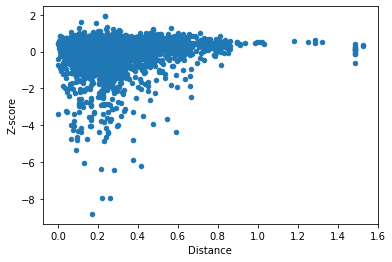

In [21]:
# create a scatter plot of distance vs z_score
shooting_df.plot(kind='scatter', x='distance', y='z_score')

# set the x and y axis labels
plt.xlabel('Distance')
plt.ylabel('Z-score')

# display the plot
plt.show()

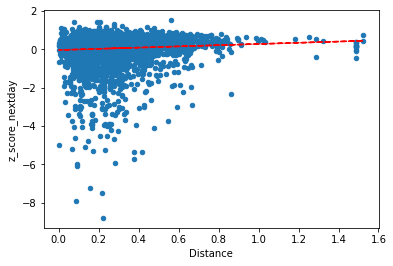

In [23]:
# create a scatter plot of distance vs z_score
shooting_df.plot(kind='scatter', x='distance', y='z_score_nextday')

# calculate the best-fit line using numpy's polyfit function
x = shooting_df['distance']
y = shooting_df['z_score_nextday']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# plot the best-fit line
plt.plot(x,p(x),"r--")

# set the x and y axis labels
plt.xlabel('Distance')
plt.ylabel('z_score_nextday')

# display the plot
plt.show()

In [24]:
school_df=school_df.merge(shooting_df[['nearest_id','occur_date']],left_on=['school','date'],right_on=['nearest_id','occur_date'],how='left')
school_df=school_df.merge(shooting_df[['nearest_id','occur_date_plus1']],left_on=['school','date'],right_on=['nearest_id','occur_date_plus1'],suffixes=(None,'_nextday'),how='left')
school_df['shooting'] = school_df['nearest_id'].notnull()| school_df['nearest_id_nextday'].notnull()
school_df.drop(['nearest_id','occur_date','nearest_id_nextday','occur_date_plus1'],axis=1,inplace=True)

In [25]:
school_df

,school,date,schoolyear,enrolled,present,absent,released,longitude,latitude,month,attendance,mean,std,z_score,shooting
0,01M015,2006-09-05,20062007,252.0,226.0,26.0,0.0,-73.979022,40.721807,9,0.896825,0.862151,0.096213,0.360397,False
1,01M019,2006-09-05,20062007,323.0,290.0,33.0,0.0,-73.983818,40.729636,9,0.897833,0.862151,0.096213,0.370868,False
2,01M020,2006-09-05,20062007,650.0,605.0,45.0,0.0,-73.986648,40.721540,9,0.930769,0.862151,0.096213,0.713197,False
3,01M034,2006-09-05,20062007,376.0,325.0,51.0,0.0,-73.975181,40.726473,9,0.864362,0.862151,0.096213,0.022981,False
4,01M063,2006-09-05,20062007,210.0,193.0,17.0,0.0,-73.986381,40.724117,9,0.919048,0.862151,0.096213,0.591367,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992411,27Q333,2015-09-08,20152016,560.0,559.0,1.0,0.0,-73.786182,40.593967,117,0.998214,0.795203,0.182440,1.112754,False
2992412,07X527,2016-09-07,20162017,492.0,310.0,182.0,0.0,-73.923829,40.822310,129,0.630081,0.630081,NaN,NaN,False
2992413,17K354,2017-04-17,20162017,221.0,107.0,114.0,0.0,-73.936924,40.672713,136,0.484163,0.484163,NaN,NaN,False
2992414,17K354,2017-04-18,20162017,221.0,153.0,68.0,0.0,-73.936924,40.672713,136,0.692308,0.785015,0.131108,-0.707107,False


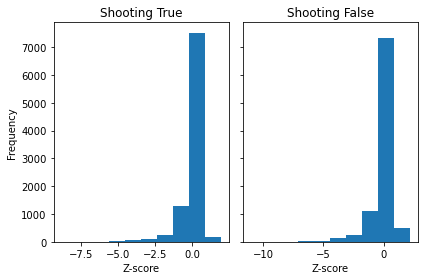

In [26]:
import pandas as pd
import matplotlib.pyplot as plt


# create two sub-dataframes for when shooting is true and when it is false
shooting_true = school_df[school_df['shooting'] == True]
shooting_false = school_df[school_df['shooting'] == False]
shooting_false = shooting_false.sample(n=shooting_true.shape[0], random_state=42)


# create a figure with two subplots
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# plot the histograms for z_score when shooting is true and false in the respective subplots
axs[0].hist(shooting_true['z_score'])
axs[1].hist(shooting_false['z_score'])

# set the titles for each subplot
axs[0].set_title('Shooting True')
axs[1].set_title('Shooting False')

# set the x and y axis labels
axs[0].set_xlabel('Z-score')
axs[1].set_xlabel('Z-score')
axs[0].set_ylabel('Frequency')

# display the plot
plt.show()


In [27]:
shooting_true.z_score.mean(),shooting_false.z_score.mean()

(0.04587380372335885, -0.004350946685022976)

In [28]:
shooting_true.z_score.mean(),shooting_false.z_score.mean()

(0.04587380372335885, -0.004350946685022976)

In [29]:
len(shooting_true),len(shooting_false)

(9388, 9388)